In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])

# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# MobileNetV2 için ön işleme fonksiyonu
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.


In [2]:
from tensorflow.keras.applications import MobileNetV2

# MobileNetV2 modelini yükle
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetv2_model.keras', save_best_only=True, monitor='val_accuracy')
epochs = 100

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 256s 893ms/step - accuracy: 0.7032 - loss: 0.8855 - val_accuracy: 0.8529 - val_loss: 0.4603
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 859ms/step - accuracy: 0.8345 - loss: 0.4857 - val_accuracy: 0.8547 - val_loss: 0.4295
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 859ms/step - accuracy: 0.8423 - loss: 0.4393 - val_accuracy: 0.8622 - val_loss: 0.3936
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 859ms/step - accuracy: 0.8507 - loss: 0.4250 - val_accuracy: 0.8682 - val_loss: 0.3827
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 859ms/step - accuracy: 0.8474 - loss: 0.4154 - val_accuracy: 0.8663 - val_loss: 0.3798
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 856ms/step - accuracy: 0.8522 - loss: 0.4049 - val_accuracy: 0.8659 - val_loss: 0.3829
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 858ms/step - accuracy: 0.8523 - loss: 0.4017 - val_accuracy: 0.8616 - val_loss: 0.4003
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 237s 860ms/step - accuracy: 

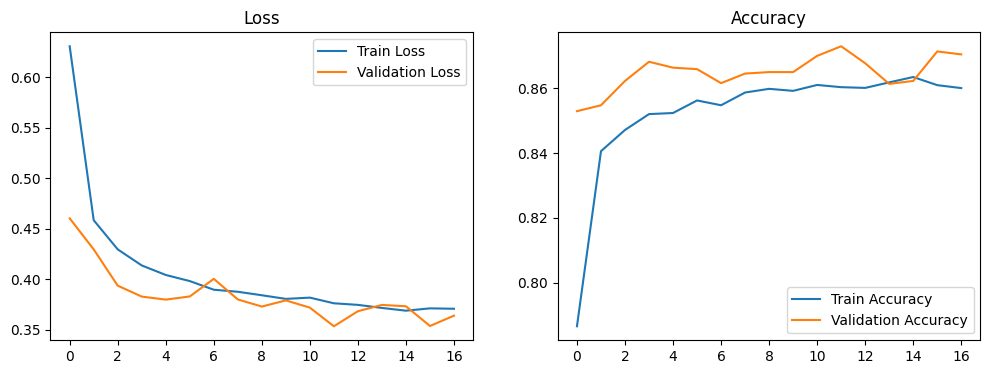

In [4]:
# Eğitim ve doğrulama kaybını ve doğruluğunu çiz
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [5]:
# Test veri seti üzerinde modeli değerlendir
test_loss, test_accuracy = model.evaluate(test_dataset)

# Sonuçları yazdır
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8543 - loss: 0.3518
Test Loss: 0.3534
Test Accuracy: 0.8730


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n",cmp)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━

Sınıf İsimleri: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
Seçilen Sınıf: O
Seçilen Görsel: /kaggle/input/classed-odir5k-splited-into-train-test/test/O/aug_0_9736.jpg


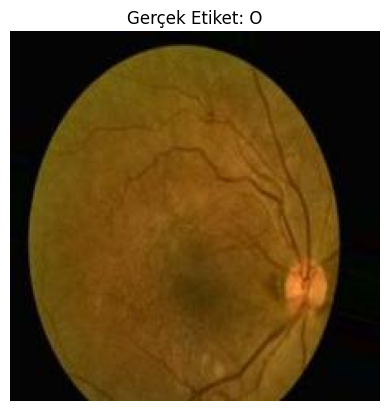

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Gerçek Etiket: O
Tahmin Edilen Etiket: O
Tahmin Olasılıkları: [0.02018144 0.09380678 0.06592768 0.00735735 0.00249921 0.00678006
 0.32497507 0.4784724 ]


In [14]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Test dizinindeki klasörleri (sınıfları) al
class_names = sorted(os.listdir(test_dir))  # Klasör adlarını al
print("Sınıf İsimleri:", class_names)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
print("Seçilen Sınıf:", random_class)

# Seçilen sınıftan rastgele bir görsel seç
random_image_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))
print("Seçilen Görsel:", random_image_path)

# Görseli yükle ve ön işleme yap
img = tf.keras.preprocessing.image.load_img(random_image_path, target_size=img_size)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği şekilde (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Görseli göster
plt.imshow(img)
plt.title(f"Gerçek Etiket: {random_class}")
plt.axis('off')
plt.show()

# Tahmin yap
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]  # En yüksek olasılığa sahip sınıf

# Sonucu yazdır
print(f"Gerçek Etiket: {random_class}")
print(f"Tahmin Edilen Etiket: {predicted_class}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

Attention

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 254s 890ms/step - accuracy: 0.7340 - loss: 0.7913 - val_accuracy: 0.8556 - val_loss: 0.4349
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 854ms/step - accuracy: 0.8449 - loss: 0.4297 - val_accuracy: 0.8648 - val_loss: 0.3844
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 854ms/step - accuracy: 0.8555 - loss: 0.3919 - val_accuracy: 0.8657 - val_loss: 0.3668
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 857ms/step - accuracy: 0.8595 - loss: 0.3759 - val_accuracy: 0.8691 - val_loss: 0.3512
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 856ms/step - accuracy: 0.8632 - loss: 0.3704 - val_accuracy: 0.8570 - val_loss: 0.3887
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 853ms/step - accuracy: 0.8639 - loss: 0.3677 - val_accuracy: 0.8602 - val_loss: 0.3760
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 852ms/step - accuracy: 0.8657 - loss: 0.3619 - val_accuracy: 0.8632 - val_loss: 0.3814
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 237s 861ms/step - accuracy: 

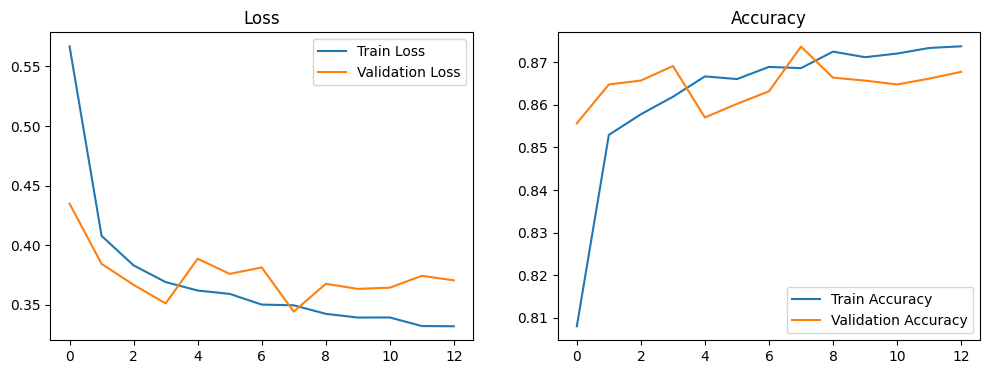

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Multiply, Conv2D, Activation, Reshape, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Channel Attention Modülü
class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.gap = GlobalAveragePooling2D()
        self.dense1 = None
        self.dense2 = None

    def build(self, input_shape):
        channels = input_shape[-1]
        self.dense1 = Dense(units=int(channels / self.ratio), activation='relu')
        self.dense2 = Dense(units=channels, activation='sigmoid')
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        gap = self.gap(inputs)
        fc1 = self.dense1(gap)
        fc2 = self.dense2(fc1)
        fc2 = Reshape((1, 1, fc2.shape[1]))(fc2)
        return Multiply()([inputs, fc2])

# Spatial Attention Modülü
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = Conv2D(filters=1, kernel_size=self.kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return Multiply()([inputs, attention])

# MobileNetV2 modelini yükle
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model mimarisi
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Tüm modeli çağır

# Attention modüllerini belirli katmanlara ekle
x = ChannelAttention()(x)
x = SpatialAttention()(x)

# Global Average Pooling ve diğer katmanlar
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)

# Modeli oluştur
model = tf.keras.Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetv2_attention_model.keras', save_best_only=True, monitor='val_accuracy')

# Modeli eğit
epochs = 100
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

# Eğitim ve doğrulama kaybını ve doğruluğunu çiz
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n",cmp)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━